# Results

## CUB200 InceptionV3 Features

*Small Reminder:* Baseline should be the same for all setups. Otherwise, something is wrong with the features!

| Part Type | # parts | Global part only<br> <small>*Baseline*</small> | All parts | All parts<br> <small>*Local parts shuffled*</small> | Local parts only | Local parts only<br>  <small>*Local parts shuffled*</small>  |
|-|-|
|  GT Parts | 15 | 87.64 % | **89.45 %** | 89.06¹ % | 85.59 % | 80.60¹ % |
| GT2 Parts | 4  | 87.64 % | **88.94 %** | 88.76¹ % | 84.78 % | 77.77¹ % |
| NAC Parts | 20 | 87.64 % | **88.85 %** | 88.21¹ % | 86.26 % | 83.71¹ % |


¹ - needs more runs, since randomness involved

In [1]:
%load_ext autoreload
%autoreload 2

In [75]:
import numpy as np
import joblib

from os.path import join
from matplotlib import pyplot as plt
from jupyter_utils.progress_bar import ProgressBar
from functools import partial

from nabirds import CUB_Annotations, NAB_Annotations, Dataset
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [76]:
BASE_DIR = "/home/korsch/Data"

infos = dict(
    
    # VGG19 Features
    
    NAC_single=dict(
        data="NAC/2017-bilinear",
        feat_suffix="10parts_new"
    ),
    
    NAC_vgg=dict(
        data="NAC/2017-bilinear",
        feat_suffix="20parts"
    ),
    
    
    # ResNet50 Features
    
    NAC_resnet=dict(
        data="NAC/2017-bilinear",
        feat_suffix="20parts.resnet"
    ),
    
    GT_resnet=dict(
        data="cub200_11",
        feat_suffix="16parts_gt.resnet"
    ),
    
    # InceptionV3 Features
    
    NAC_inception=dict(
        data="NAC/2017-bilinear",
        feat_suffix="20parts.inception"
    ),
    GT_inception=dict(
        data="cub200_11",
        feat_suffix="16parts_gt.inception"
    ),
    
    GT2_inception=dict(
        data="cub200_11_regrouped",
        feat_suffix="5parts_gt.inception"
    )
)
DATASET="NAC_inception"
info = infos[DATASET]
DATA_DIR = join(BASE_DIR, "DATASETS", "birds", info["data"])

DUMP = True

# Load data

In [4]:
print("Loading annotations from \"{}\"...".format(DATA_DIR))
annot = CUB_Annotations(DATA_DIR)

print("Creating train and test datasets")
splits = [annot.train_uuids, annot.test_uuids]
features = [join(DATA_DIR, "features", "{}_{}.npz".format(s, info["feat_suffix"])) 
            for s in ["train", "val"]]

train, val = [Dataset(uuids=s, annotations=annot, features=feats) 
               for s, feats in zip(splits, features)]

train_feats = train.features
val_feats = val.features

part_names = list(train._annot.part_name_list)
if "NAC" in DATASET and "single" not in DATASET:
    part_names *= 2
part_names.append("GLOBAL")
assert train_feats is not None
assert val_feats is not None

Loading annotations from "/home/korsch/Data/DATASETS/birds/NAC/2017-bilinear"...
Creating train and test datasets


# Some Feature Stats

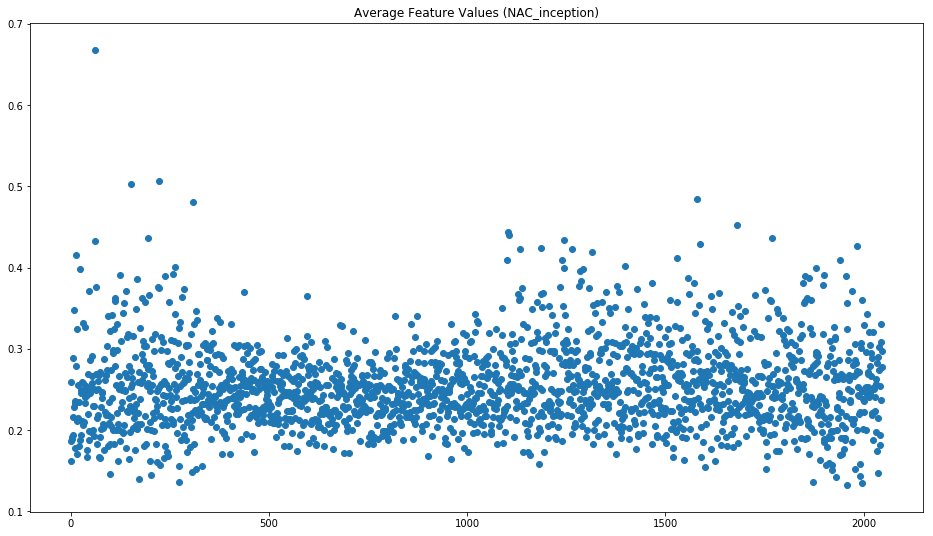

In [7]:
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(range(2048), train_feats.mean(axis=(0,1)))
ax.set_title("Average Feature Values ({})".format(DATASET))
plt.show()

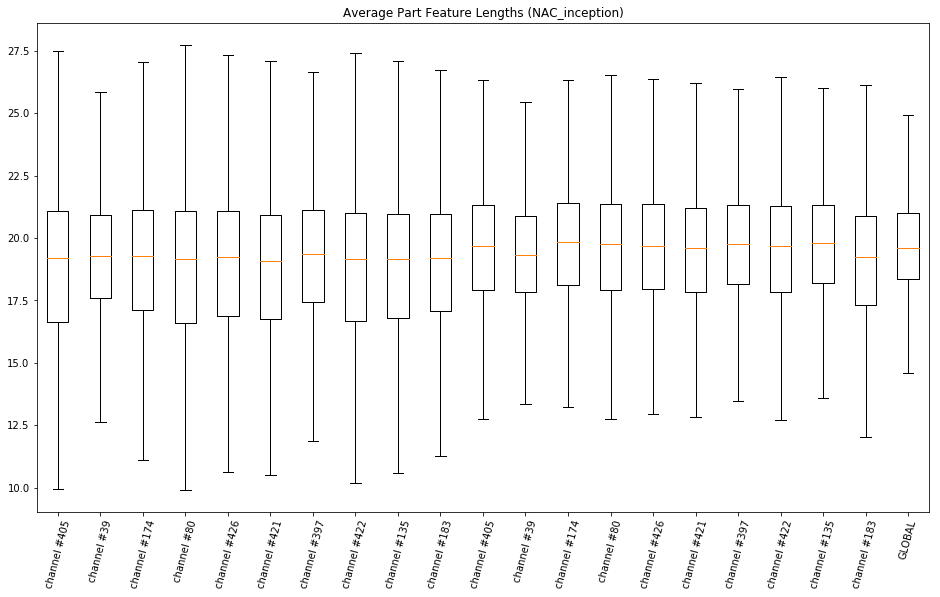

In [8]:
import matplotlib.pyplot as plt

feature_norms = np.sqrt(np.sum(train_feats ** 2, axis=-1))
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title("Average Part Feature Lengths ({})".format(DATASET))
ax.boxplot(feature_norms, showfliers=False)
ax.set_xticklabels(part_names, rotation=75)
plt.show()

In [77]:
def evaluate(X, y, X_val, y_val, clf_class=LinearSVC, scale=False):
    print(X.shape, X_val.shape)
    print(y, y_val)
    
    if scale:
        print("Scaling Data...")
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
        X_val = scaler.transform(X_val)
    print("Training Classifier...")
    clf = clf_class()
    %time clf.fit(X, y)
    return clf, clf.score(X_val, y_val)

# Train SVM with sparse feature coefficients

In [80]:
X, y = train_feats[:, -1, :], train.labels
X_val, y_val = val_feats[:, -1, :], val.labels

clf_class = partial(LinearSVC, penalty="l1", C=1, dual=False, max_iter=10000)
clf, score = evaluate(X, y, X_val, y_val, clf_class, scale=True)

print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_glob_only_sparse_coefs.npz".format(DATASET))
    

(5994, 2048) (5794, 2048)
[  0   0   0 ... 199 199 199] [  0   0   0 ... 199 199 199]
Scaling Data...
Training Classifier...
CPU times: user 2min 33s, sys: 8.89 s, total: 2min 42s
Wall time: 2min 42s
87.33%


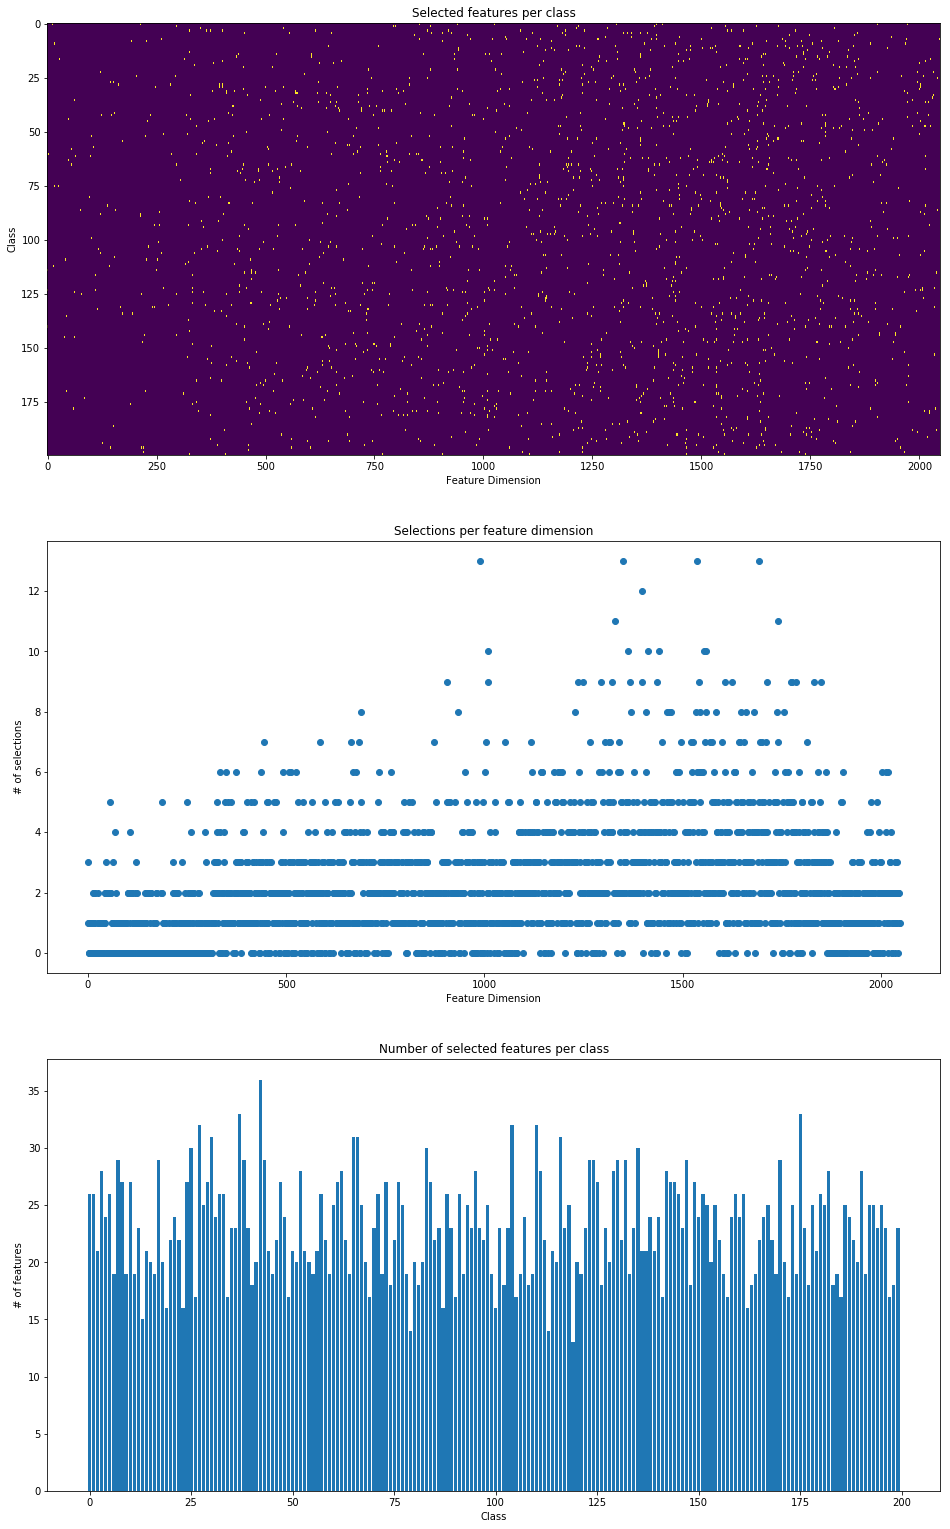

In [99]:
clf = joblib.load("clf_{}_glob_only_sparse_coefs.npz".format(DATASET))
fig, ax = plt.subplots(3, 1, figsize=(16, 9*3))
ax[0].set_title("Selected features per class")
ax[0].set_xlabel("Feature Dimension")
ax[0].set_ylabel("Class")
ax[0].imshow(clf.coef_ != 0, aspect="auto")

ax[1].set_title("Selections per feature dimension")
ax[1].set_xlabel("Feature Dimension")
ax[1].set_ylabel("# of selections")
# ax[1].imshow((clf.coef_ != 0).sum(axis=0, keepdims=True), aspect="auto")
ax[1].scatter(range(clf.coef_.shape[1]), (clf.coef_ != 0).sum(axis=0))

ax[2].set_title("Number of selected features per class")
ax[2].set_xlabel("Class")
ax[2].set_ylabel("# of features")
ax[2].bar(range(len(clf.coef_)), (clf.coef_ != 0).sum(axis=1))
plt.show()
plt.close()

print()

# Train SVM on global part only

In [82]:
X, y = train_feats[:, -1, :], train.labels
X_val, y_val = val_feats[:, -1, :], val.labels

clf, score = evaluate(X, y, X_val, y_val)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_glob_only.npz".format(DATASET))

(5994, 2048) (5794, 2048)
[  0   0   0 ... 199 199 199] [  0   0   0 ... 199 199 199]
Training Classifier...
CPU times: user 29.5 s, sys: 15 µs, total: 29.5 s
Wall time: 29.5 s
87.64%


# Train SVM on all parts

In [8]:
X, y = train_feats.reshape(len(train), -1), train.labels
X_val, y_val = val_feats.reshape(len(val), -1), val.labels

clf, score = evaluate(X, y, X_val, y_val)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_all_parts.npz".format(DATASET))

(5994, 43008) (5794, 43008)
[  0   0   0 ... 199 199 199] [  0   0   0 ... 199 199 199]
CPU times: user 9min 32s, sys: 1.3 s, total: 9min 33s
Wall time: 9min 33s
88.85%


['clf_NAC_inception_all_parts.npz']

# Train SVM on local parts only

In [9]:
X, y = train_feats[:, :-1, :].reshape(len(train), -1), train.labels
X_val, y_val = val_feats[:, :-1, :].reshape(len(val), -1), val.labels

clf, score = evaluate(X, y, X_val, y_val)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_local_parts.npz".format(DATASET))

(5994, 40960) (5794, 40960)
[  0   0   0 ... 199 199 199] [  0   0   0 ... 199 199 199]
CPU times: user 15min 28s, sys: 2.12 s, total: 15min 31s
Wall time: 15min 31s
86.26%


['clf_NAC_inception_local_parts.npz']

# Shuffle Part Positions

Shuffle parts for each sample. Leave global feature on the correct place.

In [10]:
train_feats_rnd = train_feats.copy()
val_feats_rnd = val_feats.copy()

bar = ProgressBar()

[np.random.shuffle(f[:-1]) for f in bar(train_feats_rnd)]
[np.random.shuffle(f[:-1]) for f in bar(val_feats_rnd)]

print("shuffling ready")

shuffling ready


# Train SVM on all parts

In [11]:
X, y = train_feats_rnd.reshape(len(train), -1), train.labels
X_val, y_val = val_feats_rnd.reshape(len(val), -1), val.labels

clf, score = evaluate(X, y, X_val, y_val)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_all_parts_shuffled.npz".format(DATASET))

(5994, 43008) (5794, 43008)
[  0   0   0 ... 199 199 199] [  0   0   0 ... 199 199 199]
CPU times: user 13min 27s, sys: 1.59 s, total: 13min 29s
Wall time: 13min 29s
88.18%


['clf_NAC_inception_all_parts_shuffled.npz']

# Train SVM on local parts only

In [12]:
X, y = train_feats_rnd[:, :-1, :].reshape(len(train), -1), train.labels
X_val, y_val = val_feats_rnd[:, :-1, :].reshape(len(val), -1), val.labels

clf, score = evaluate(X, y, X_val, y_val)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_local_parts_shuffled.npz".format(DATASET))

(5994, 40960) (5794, 40960)
[  0   0   0 ... 199 199 199] [  0   0   0 ... 199 199 199]
CPU times: user 11min 33s, sys: 1.76 s, total: 11min 35s
Wall time: 11min 35s
83.59%


['clf_NAC_inception_local_parts_shuffled.npz']